# Misc KBO planning calculations

### Look at brightness of Chariklo vs. its ring

In [227]:
import astropy.units as u
import astropy.constants as c
import math
import numpy as np
import matplotlib.pyplot as plt
import pymiecoated

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) # Caused by pymiecoated 

import matplotlib                                    # Set latex to use *not* CMR.
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'

r2d = 360 / (2*math.pi)
d2r = 1/r2d

r_chariklo = 315*u.km

r_ring = np.array([396, 405])*u.km
dr_ring = np.array([7, 3.5])*u.km
tau_ring = np.array([0.4, 0.06])

r_mu69 = 20*u.km

Conventions to adopt here:
* All angles are the phase angle $\phi$. 180 = forward; 0 = backscatter.
* Scattering angle is $\alpha$, but I try not to use it. My papers also use $\theta$ to be scattering angle.
* Hal's plot of stray light is *opposite* to this ('Angle from sun'). I don't use his convention.
* Keep all angles internally in radians

In [228]:
area_chariklo = math.pi * (r_chariklo**2)
area_mu69 = math.pi * (r_mu69**2)
area_ring = np.sum( 2 *math.pi * (r_ring * dr_ring) * tau_ring )

In [229]:
area_chariklo / area_ring

<Quantity 41.556728232189975>

In [230]:
area_mu69 / area_ring

<Quantity 0.16752523348829418>

In [231]:
area_ring.to('km^2')

<Quantity 7501.180778976349 km2>

Concl: So, even for Chariklo, the total surface area of the ring is only a few percent. At backscatter, ring is tiny. But at forward-scatter, moon gets fainter to 0.05 fraction (at 140 deg phase) and ring probably gets brighter. So then ring is brighter than moon! This would not be a subtle effect. It would totally dominate the phase curve. Chariklo's phase curve must look essentially flat... it would be totally weird-looking. I could make a simple estimate of it by just adding a lambertian and a single mie curve.

If Chariklo's rings were in orbit around MU69, they would be many times brighter than body, even at backscatter.

### To do: make a plot of Mie phase curve + Lambertian phase curve

## Calculate DN of KBO observation

What we want here:
* Assume a v=20 KBO, at 140 deg phase. This is the worst case. Calculate DN/pixel/sec for this.
* Calculate the stray light in LORRI. Hal's table gives this in I/F, and we can convert this to DN/sec/pixel.
* One of these conversions uses unresolved. One uses resolved. So, we use RSOLAR and PSOLAR.

To convert to DN, we use<br>
`V = -2.5 log S + PHOTZPT + CC + BC`<br>
i.e.,<br>
`S = exp((BC + CC + PHOTZPT - V) / 2.5)`<br>
* `V` = mag
* `PHOTZPT` = zero pount for LORRI = 18.94 (from Hal's paper)
* `CC` = Color Correction. Assume zero since reflected solar.
* `S` = Integrated net signal rate from target, in DN/sec
* `BC` = Aperture Correction. Assume zero I think? Doesn’t really say.

In [232]:
V         = 20 # V mag of distant KBO
phase_deg = 140 # Phase angle, in degrees
PHOTZPT   = 18.94 # LORRI Photometric z-point
F         = 176 # Solar flux

In [233]:
math.exp((PHOTZPT - V)/2.5) # Calculate DN/sec for an unresolved source, LORRI

0.6544238819088589

### Define the stray light at Pluto, from LORRI

In [234]:
IoF_stray_lorri_pluto_arr = np.transpose(np.array([
                        [0.1, 100], # Take the raw data from Hal's plot. Angle from sun in Deg, and I/F.
                        [1, 10],
                        [2, 1],
                        [15, 1.5e-2],
                        [20, 2e-3],
                        [25, 1e-3],
                        [30, 8e-4],
                        [50, 1e-4],
                        [60, 3e-5],
                        [75,1e-5]]))

### Now flip this around so it's a function of phase angle (not scattering angle).
NB: These I/F values are correct for 33 AU. At other distances, need to multiply by (33/dist_au)**2.

In [235]:
angle_stray = IoF_stray_lorri_pluto_arr[0,:]
phi_stray = (180 - angle_stray) * d2r # Phase angle, in radians
IoF_stray_lorri_pluto = IoF_stray_lorri_pluto_arr[1,:]

# Convert Hal's chart values from I/F, to DN, using conversion constant on that chart.

S_stray_lorri_pluto = IoF_stray_lorri_pluto * (10 / 8e-4) # DN/sec/pixel [blue dashed line in Hal's slide]

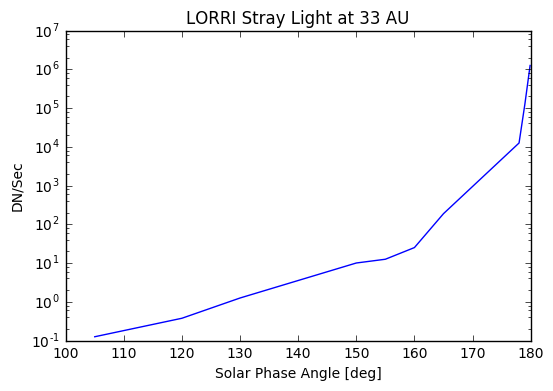

In [236]:
plt.plot(phi_stray*r2d, S_stray_lorri_pluto)
plt.yscale('log')
plt.xlabel('Solar Phase Angle [deg]')
plt.ylabel('DN/Sec')
plt.title('LORRI Stray Light at 33 AU')
plt.show()

### Define the Lambertian phase function

In [237]:
def phase_function_lambert(alpha):
    '''Returns phase function, given phase angle phi in radians. '''
    return (8/(3*math.pi) * (np.sin(phi) + (math.pi - phi)*np.cos(phi) ))

### Define the Mie phase function

In [238]:
def phase_function_mie(x, n_refract, phi):
    '''Returns phase function, given phase angle phi in radians.'''
    p11 = [] # List for the output array (n_x  X  n_angles)

    alpha = math.pi - phi                               # alpha is scattering angle. Phi is phase angle.
    
    for x_i in x:
        mie    = pymiecoated.Mie(x=x_i,m=n_refract)
        p11_i  = []     # Create the output arrays for each individual angular phase function

        for a in alpha: # Loop over angle
            S12 = mie.S12(np.cos(a))                    # Get the Mie coefficient using pymiecoated library
            p11_i.append(np.abs(S12[0]**2 + S12[1]**2)) # Compute the amplitude at each angle

        p11_i = np.array(p11_i)                         # Save the result
        p11.append(p11_i)

    p11_arr = np.array(p11)
    p11_out = np.sum(p11_arr,0)                         # Average all the phase functions together into one

    dalpha = abs(alpha[1] - alpha[0]) 
    p11 = p11_out
    p11 = p11 * 2 / (np.sum(p11 * np.sin(alpha) * dalpha)) # Normalize the phase function integral to 2

    return p11

In [239]:
phi       = np.array(range(100))*math.pi/100 # Phase angles
n_refract = complex(1.5, 5e-4)
x         = np.array([40, 50, 60, 52, 55]) # Make a phase function that is a sum of all of these X values

### Do some calculations to generate a sample phase curve for a ring and a solid body

In [240]:
p11_mie_bright = phase_function_mie(x, n_refract, phi)               # 'Normal' dusty rings
p11_mie_dark   = phase_function_mie(x*10, complex(1.5, 0.5), phi)    # Darker, more absorbing rings (in theory) 
p11_lambert    = phase_function_lambert(phi)

### Now the basic idea is done. Now all we need to do it calibrate it.

Calculate lambertian in DN/s.

Let's take a typical encounter.
v=

In [241]:
V    = 15              # Magnitude of KBO. But hang on -- is this from NH, or from ground, or what? What phase angle, etc?
dist = 40              # Orbital distance, in AU. KBO flybys are mostly 2017 - 2018, at distances 37 .. 42 AU.
dist_pluto_ca = 33     # Distance of the Pluto close-approach, in AU

# Create the phase function for the KBO body

S_kbo         = math.exp((PHOTZPT - V)/2.5) # Calculate DN/sec for an unresolved source of a given mag, LORRI
S_kbo_lambert = p11_lambert * (S_kbo / p11_lambert[0]) # Multiply this by a Lambertian phase func

# Create the phase function for the KBO rings

ratio_ring_body = 0.1           # Brightness ratio, at backscatter. (ie, area ratio of rings : central_body)

S_kbo_mie_bright = p11_mie_bright * (S_kbo / p11_mie_bright[0]) * ratio_ring_body
S_kbo_mie_dark   = p11_mie_dark   * (S_kbo / p11_mie_dark[0])   * ratio_ring_body



### And make a plot of the two phase curves, plus the stray light curve

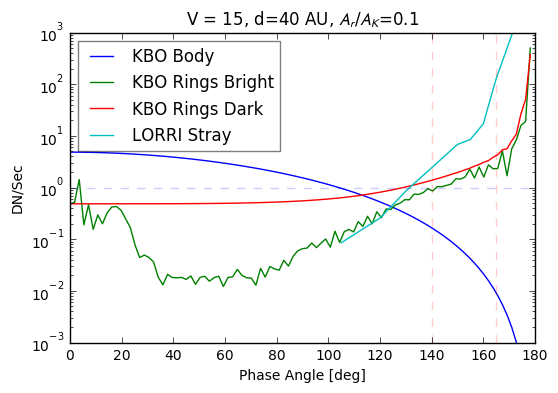

In [246]:
plt.plot(phi*r2d,       S_kbo_lambert,       label = 'KBO Body')
plt.plot(phi*r2d,       S_kbo_mie_bright,    label = 'KBO Rings Bright')
plt.plot(phi*r2d,       S_kbo_mie_dark,      label = 'KBO Rings Dark')
plt.plot(phi_stray*r2d, S_stray_lorri_pluto * (dist_pluto_ca/dist)**2, label = 'LORRI Stray')
plt.axhline(y=1, linestyle='--', alpha=0.2)                  # Horizontal dashed line at 1 DN/sec
plt.axvline(x=165, linestyle='--', color='red', alpha=0.2)   # Vertical dashed line at departure asymptote
plt.axvline(x=140, linestyle='--', color='red', alpha=0.2)   # Vertical dashed line at 140 deg (end of KBO 2016 obs)

plt.ylabel('DN/Sec')
plt.xlabel('Phase Angle [deg]')
plt.yscale('log')
plt.legend(framealpha=0.5, loc = 'upper left')
plt.ylim((1e-3, 1000))
plt.title('V = {}, d={} AU, $A_r$/$A_K$={}'.format(V, dist, ratio_ring_body))

### Concl: 
I've done a bunch of cases. In all of them, LORRI stray light really dominates past 140 deg.

I don't have a quantitative measurement here for MVIC stray light. But on rings obs on DOY 2015-202 and 2015-305, the post-reduction stray light in LORRI was 10-100x worse (in units of I/F) than MVIC (that is, after Tod removed stray light from both). 